In [1]:

from astropy.io import fits
import astropy.io.ascii # separate to not overwrite namespace 
from astropy.table import Column
from astropy import units as u
from scipy import optimize
from os.path import expanduser
# from ROOT import TRolke

%pylab inline
#%matplotlib inline


Populating the interactive namespace from numpy and matplotlib


In [2]:
home = expanduser("~")
gc_dir = home + "/Dropbox/GalacticCenter/"


In [3]:
erg2TeV = (u.erg).to(u.TeV)
print(erg2TeV)

pylab.rcParams['figure.figsize'] = (12.0, 6.0)
#matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)


0.624150934326018


<h2> Define functions for extracting points, fitting, and plotting </h2>

In [79]:
# define our line fitting function
fitfunc = lambda p, x: p[0] + p[1] * (x)
errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

# define our () fitting function
fitfuncECPL = lambda p, x: p[0] + p[1] * np.log(x) - (x) / p[2] # np.log is natural log  
errfuncECPL = lambda p, x, y, err: (np.log(y) - fitfuncECPL(p, x)) / (err)

fitfuncECPL_CF = lambda N0, gamma, beta, E: N0 + gamma*E - 1.*np.exp(E) / beta 


#these are just copied from http://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/python_tutorial.html
f = lambda E, N0, E0, gamma: N0*(E/E0)**(-1.*gamma)
ferr = lambda E, F, N0, N0err, E0, cov_gg: \
                F*np.sqrt(N0err**2/N0**2 + ((np.log(E/E0))**2)*cov_gg)

f_ecpl = lambda E,N0,E0,gamma,beta: N0*(E/E0)**(-1.*gamma)*np.exp(-1.*E/beta)
ferr_ecpl = lambda E, F, N0, N0err, E0, cov_gg, b, cov_bb: \
            F*np.sqrt(N0err**2/N0**2 + ((np.log(E/E0))**2) * cov_gg + (E/E0)**2 / b**4 * cov_bb)

def plotPythonFit(energy, flux, flux_err_arg, color, name, ECPL=False, E0=1., ls="--"):#, power=0.):
    """fit flux points to a curve then plot
    by default it's labeled in units of TeV, and flux / m^2
    fluxes are multiplied by E^power """

    logx = np.log(energy/E0)
    logy = np.log(flux)
    #logyerr = np.log(flux_err)

    
    if isinstance(flux_err_arg, tuple):
        flux_err = (flux_err_arg[1] + flux_err_arg[0]) / 2 
    else:
        flux_err = flux_err_arg 

    logyerr = flux_err / flux 
        
    if ECPL:
        pinit = [-26, -2.25, 10]
        out = optimize.leastsq(errfuncECPL, pinit,
                               args=(energy/E0, flux, flux_err / flux), 
                               full_output=1)

    else:

        pinit = [-26, -2.25] # nb ln
    
        out = optimize.leastsq(errfunc, pinit,
                               args=(logx, logy, logyerr), 
                               full_output=1)
    # end if else ECPL 

    pfinal = out[0]
    covar  = out[1]
    print("parameters:")
    print(pfinal)
    print("covariance matrix")
    print(covar)
    
    N0    = np.exp(pfinal[0])
    gamma = pfinal[1]
    E     = np.linspace(energy[0], energy[-1], num=100)
    
    if ECPL:
        beta = pfinal[2]
        
        F    = f_ecpl(E, N0, E0, -1.*gamma, beta)
        chi2 = np.sum((flux - f_ecpl(energy, N0, E0, -1.*gamma, beta))**2/flux_err**2) / (len(energy) - 3)
        print("chi^2: "+str(chi2)+'\n')
        beta_err  = np.sqrt( covar[2][2] ) * chi2 #* N0  
        gamma_err = np.sqrt( covar[0][0] ) * chi2
        N0_err    = np.sqrt( covar[1][1] ) * N0 * chi2
        cov_gg = gamma_err**2
        cov_bb = beta_err**2
        Ferr = ferr_ecpl(E, F, N0, N0_err, E0, cov_gg, beta, cov_bb)

        fitTitle = (name + ' - N0: {0:.2e} +- {2:.2e}, '\
                    'G: {1:.2f} +- {3:.2f}, '\
                    'Ec: {4:.2f} +- {5:.2f}, '
                    'E0: {6:.0f}').format(float(N0), float(gamma),
                                          float(N0_err), float(gamma_err),
                                          float(beta), float(beta_err), float(E0))

    else:
        F    = f(E, N0, E0, -1.*gamma)
        chi2 = np.sum((flux - f(energy, N0, E0, -1.*gamma))**2 / flux_err**2) / (len(energy) - 2)
        print(chi2)
        gamma_err = np.sqrt( covar[0][0] ) * chi2
        N0_err    = np.sqrt( covar[1][1] ) * N0 * chi2
        cov_gg = gamma_err**2
        Ferr = ferr(E, F, N0, N0_err, E0, cov_gg)
        
        fitTitle = (name + ' - N0= {0:.2e} +- {2:.2e}, '\
                    'gamma= {1:.2f} +- {3:.2f}, '\
                    'E0: {4:.2f}').format(float(N0), float(gamma),
                                          float(N0_err), float(gamma_err), float(E0))

    plt.plot(E, F * (E)**power, color=color, ls=ls, marker="", label=fitTitle)
    plt.fill_between(E, (E)**power*(F+Ferr), (E)**power*(F-Ferr), color=color, alpha='0.25')
    plt.loglog(nonposy="clip")
    plt.errorbar(energy, flux*energy**power, flux_err_arg*energy**power, 
                color=color, ls='', marker='_') # ,label=name
    plt.loglog(nonposy="clip")
    plt.xlabel("Energy [TeV]")

# end plotPythonFit 


In [5]:
def extract_points(filename):
    """extracts points from prepared spectral file"""
    with open(filename) as infile:
        # make dict 
        for line in iter(infile):
            line = line.split()
            try:
                float(line[0]) and float(line[3]) and float(line[4]) and float(line[5])
                H_energy = np.append(H_energy, float(line[0]))
                H_flux = np.append(H_flux, float(line[3]))
                H_err_up = np.append(H_err_up, float(line[4]))
                H_err_dwn = np.append(H_err_dwn, float(line[5]))
            except ValueError:
                continue 
# end extract SgrA spectral points from file     



In [70]:

def extract_spectral_points_from_log(filename):
    """takes in filename of standard root log file
    and returns array of tuples representing spectral points"""

    verbose = False 
    
    points_filename = filename.replace('_stage6', '_spectral-points')
    points_file = open(points_filename, 'w')
    
    fitparams = [0., 0., 0., 0.] # norm, index, norm_err, index_err 
    
    #handle, ulfilename = mkstemp()
    #UL_file = os.fdopen(handle, 'w')
    #UL_file = open(filename.replace('stage6', 'ULs'))
    
    with open(filename) as infile:
        foundspec = False
        specover = False 
        for line in infile:
            if foundspec and not specover:
                if line[0] == '+': # this signifies a point 
                    ls = line.split()
                    newline = ' '.join(ls[1:]) + '\n'
                    if verbose:
                        print(line)
                        print(newline)
                    points_file.write(newline)
                else:
                    try:
                        float(line[0])
                        #UL_file.write(line + '\n')
                    except ValueError:
                        specover = True
            elif specover:
                ls = line.split()
                if ls[0] == '1' and ls[1] == "Norm":
                    fitparams[0] = float(ls[2])
                    fitparams[2] = float(ls[3]) # err 
                elif ls[0] == '2' and ls[1] == "Index":
                    fitparams[1] = float(ls[2])
                    fitparams[3] = float(ls[3]) # err 
                    print(fitparams)
                    break 

            #elif line == "  Bin    Energy    error     Flux    error  Non    Noff Nexcess  RawOff Alpha    Sig  Low Edge High Edge":
            else:
                ls = line.split()
                if len(ls) >= 3 and ls[0] == "Bin" and ls[1] == "Energy" and ls[2] == "error":
                    foundspec = True 
                

    points_file.close()
    flux_points = np.genfromtxt(points_filename)

    
    #UL_array = np.genfromtxt(ulfilename)
    #UL_file.close()
    

    return flux_points, fitparams #, UL_points 
            
# end extract_spectral_points_from_log 


# HESS Points

In [6]:
# SgrA spectral points and errors 
with open(gc_dir+"spectralPoints/HESS_SgrAstar_SpectralPoints_TeV-cm2.txt") as infile:
    H_energy = np.array([])
    H_flux = np.array([])
    H_err_up = np.array([])
    H_err_dwn = np.array([])
    for line in iter(infile):
        line = line.split()
        try:
            float(line[0]) and float(line[3]) and float(line[4]) and float(line[5])
            H_energy = np.append(H_energy, float(line[0]))
            H_flux = np.append(H_flux, float(line[3]))
            H_err_up = np.append(H_err_up, float(line[4]))
            H_err_dwn = np.append(H_err_dwn, float(line[5]))
        except ValueError:
            continue 
# end extract SgrA spectral points from file     

#"/spectralPoints/HESS_Diffuse_SpectralPoints_Bins.txt"


In [7]:
print(H_err_dwn)

[  1.31137000e-11   4.32291000e-12   2.26921000e-12   1.37106000e-12
   8.56021000e-13   5.63314000e-13   3.62343000e-13   2.65156000e-13
   1.77517000e-13   1.28394000e-13   8.98834000e-14   6.25093000e-14
   4.42120000e-14   3.24015000e-14   2.39933000e-14   1.59049000e-14
   1.15732000e-14   8.04791000e-15   5.51678000e-15   3.88864000e-15
   3.22590000e-15   2.00251000e-15   1.70083000e-15   1.33694000e-15
   8.73177000e-16   0.00000000e+00   0.00000000e+00   0.00000000e+00]


In [8]:
VEGAS_Points = """
2.499 6.62e-09 5.64e-10
3.96 1.61e-09 1.01e-10
6.273 4.9e-10 3.7e-11
9.935 1.49e-10 1.43e-11
15.73 4.3e-11 5.43e-12
24.87 6.44e-12 1.55e-12
35.37 5.29e-13 5.86e-13"""

V_Points_fine = astropy.io.ascii.read(VEGAS_Points)
# convert from m^-2 to cm^-2
V_Points_fine['col2'] *= 1e-4
V_Points_fine['col3'] *= 1e-4

V_Points_fine


col1,col2,col3
float64,float64,float64
2.499,6.62e-13,5.64e-14
3.96,1.61e-13,1.01e-14
6.273,4.9e-14,3.7e-15
9.935,1.49e-14,1.43e-15
15.73,4.3e-15,5.43e-16
24.87,6.44e-16,1.55e-16
35.37,5.29e-17,5.86e-17


parameters:
[-26.329634    -2.51879462  23.00245543]
covariance matrix
[[  1.92929336e-02  -2.22082519e-02   1.46858149e+00]
 [ -2.22082519e-02   3.19728595e-02  -2.48298846e+00]
 [  1.46858149e+00  -2.48298846e+00   2.18592261e+02]]
chi^2: 3.47284262228



/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


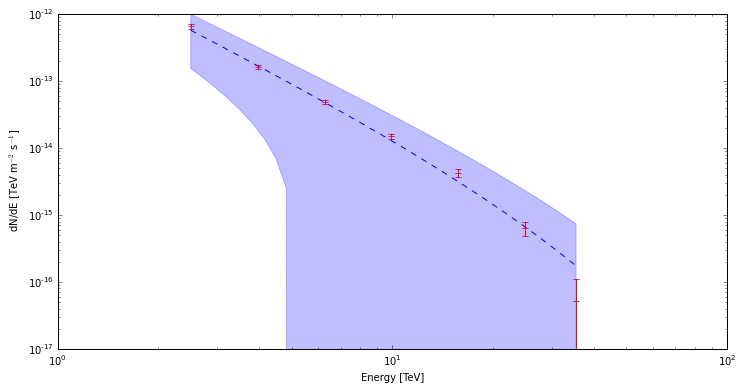

In [9]:
power = 0.
plotPythonFit(V_Points_fine['col1'], V_Points_fine['col2'], V_Points_fine['col3'], "blue", "HESS", ECPL=True, E0=1.25)
plt.errorbar(V_Points_fine['col1'], V_Points_fine['col2'] * V_Points_fine['col1']**power, 
             yerr = V_Points_fine['col3'] * V_Points_fine['col1']**power,
            label = "VERITAS 2016 Paper", ls="", marker="+", color="red")
plt.ylim(ymin=1e-17)
plt.ylabel(r" dN/dE [TeV m$^{-2}$ s$^{-1}$]")


Combine 

In [10]:
# updated VEGAS points 
# highest energy bins 
# 
VEGAS_Points = """
2.498 5.71e-09 4.03e-10
3.96 1.7e-09 1.08e-10
6.276 5.48e-10 4.15e-11
9.946 1.69e-10 1.69e-11
15.76 6.07e-11 7.63e-12
24.98 6.81e-12 2.67e-12
39.6 2.39e-13 7.91e-13 """

VEGAS_Points = """
2.498   6.82e-09    5.97e-10
3.959   1.69e-09    1.08e-10
6.274   5.42e-10    4.14e-11
9.943   1.67e-10    1.69e-11
15.76   6.00e-11    7.63e-12
24.98   1.02e-11    2.59e-12
39.59   1.03e-12    7.56e-13 """

V_Points = astropy.io.ascii.read(VEGAS_Points)
# convert from m^-2 to cm^-2
V_Points['col2'] *= 1e-4 #* erg2TeV
V_Points['col3'] *= 1e-4 #* erg2TeV

V_Points


col1,col2,col3
float64,float64,float64
2.498,6.82e-13,5.97e-14
3.959,1.69e-13,1.08e-14
6.274,5.42e-14,4.14e-15
9.943,1.67e-14,1.69e-15
15.76,6e-15,7.63e-16
24.98,1.02e-15,2.59e-16
39.59,1.03e-16,7.56e-17


In [11]:
Andy_Points = '''
2.813 3.44e-13 4.52e-14 
3.541 2.17e-13 2.43e-14
4.458 1.23e-13 1.37e-14
5.613 5.13e-14  7.4e-15
7.066 2.72e-14  4.3e-15
8.896 1.27e-14 2.48e-15
12.49  5.8e-15 8.86e-16
 19.8 1.44e-15 3.36e-16
31.39 1.22e-16 8.14e-17'''

A_Points = astropy.io.ascii.read(Andy_Points)
A_Points['col2'] *= 1 / erg2TeV
A_Points['col3'] *= 1 / erg2TeV

print(log10(A_Points['col1']*erg2TeV))

#A_Points


     col1     
--------------
0.244459357134
0.344415551727
0.444429689113
0.544484667188
0.644463258067
0.744484399207
0.891852063343
 1.09195481523
 1.29208094067


In [26]:
print(And_p)
print(A_Points)
print(1.114e-15*(17.3929)**2)



[[  2.80313477e+00   4.44878283e-08]
 [  3.52468588e+00   4.44878283e-08]
 [  4.45876578e+00   4.05546074e-08]
 [  5.57279796e+00   2.67384162e-08]
 [  7.00728430e+00   2.22194686e-08]
 [  8.81101982e+00   1.62575567e-08]
 [  1.24234106e+01   1.48202071e-08]
 [  1.96423623e+01   9.32930403e-09]
 [  3.10560771e+01   1.97916687e-09]]
 col1        col2              col3      
----- ----------------- -----------------
2.813  5.5114873836e-13  7.2418380738e-14
3.541 3.47672314605e-13 3.89328905295e-14
4.458 1.97067717495e-13 2.19498189405e-14
5.613 8.21916577845e-14  1.1856106581e-14
7.066  4.3579202568e-14  6.8893592295e-15
8.896 2.03476423755e-14  3.9733978812e-15
12.49   9.292624077e-15 1.41952843659e-15
 19.8  2.3071342536e-15  5.3833132584e-16
31.39  1.9546554093e-16 1.30417172391e-16
3.3699944903674e-13


parameters:
[-26.70246008  -2.15662883  11.70791671]
covariance matrix
[[  9.62471330e-04   7.15355259e-04  -6.56259924e-02]
 [  7.15355259e-04   7.44671130e-04  -5.40581112e-02]
 [ -6.56259924e-02  -5.40581112e-02   5.79076641e+00]]
chi^2: 1.05253097649



/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


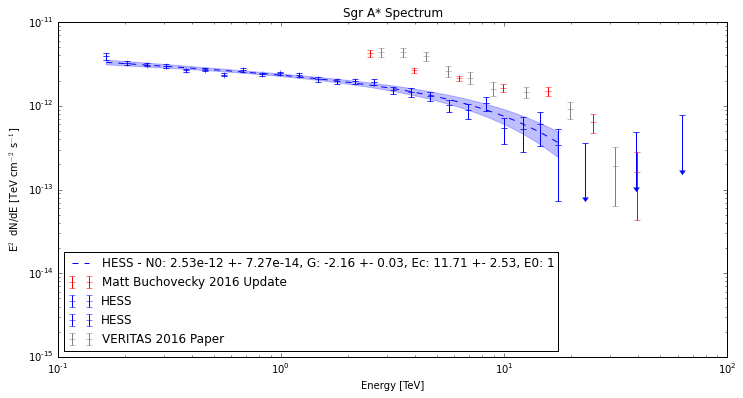

In [12]:
power = 2.

# my VEGAS points
#plotPythonFit(V_Points['col1'], V_Points['col2'], V_Points['col3'], "M2016", "red", ECPL=True, E0=1.0)
plt.errorbar(V_Points['col1'], V_Points['col2'] * V_Points['col1']**power, 
             yerr = V_Points['col3'] * V_Points['col1']**power,
             label = "Matt Buchovecky 2016 Update", ls="", marker="+", color="red")

# HESS points
plotPythonFit(H_energy[:-3], H_flux[:-3], (H_err_dwn[:-3],H_err_up[:-3]), 
              "blue", "HESS", ECPL=True)
plt.errorbar(H_energy[:-3], H_energy[:-3]**2*H_flux[:-3], 
             yerr=H_energy[:-3]**2*(H_err_dwn[:-3], H_err_up[:-3]), 
             marker="+", ls="", color="blue", label="HESS")
plt.errorbar(H_energy[-3:], H_energy[-3:]**2*H_flux[-3:], 
             yerr=(H_energy[-3:]**2*H_err_up[-3:], H_energy[-3:]**2*H_err_dwn[-3:]), 
             marker="_", ls="", uplims=True, color="blue")

# Andy's points 

plt.errorbar(A_Points['col1'], A_Points['col2'] * A_Points['col1']**power, 
             yerr = A_Points['col3'] * A_Points['col1']**power,
            label = "VERITAS 2016 Paper", ls="", marker="+", color="gray")

# plot format and save 
plt.title("Sgr A* Spectrum ")
plt.loglog(nonposy="clip")
plt.ylim(ymin=1e-15)
plt.legend(loc="best")
plt.xlabel("Energy [TeV]")
plt.ylabel(r"E$^2$ dN/dE [TeV cm$^{-2}$ s$^{-1}$]")

plt.savefig(gc_dir+"/plots/spectra/SgrA_spectra_HESSoverlay_wAndy_ECPL.png")


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


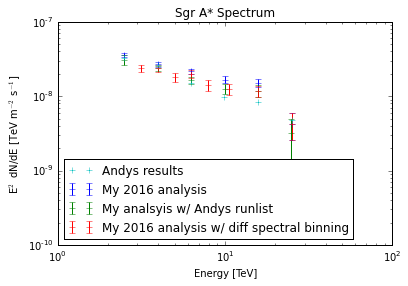

In [49]:
power = 2.
# pulled 
#plt.plot(And_p[:,0], And_p[:,1]*And_p[:,0]**(power-2.)*erg2TeV, label="Andy 2016 - pulled from paper", ls="", marker="+")
# A_Points[:,2]*And_p[:,0]**(power-2.)*erg2TeV,

# sent
#plt.errorbar(A_Points['col1'], A_Points['col2']*1e4*A_Points['col1']**(power)*erg2TeV, yerr=A_Points['col3']*1e4*A_Points['col1']**(power)*erg2TeV, label="VERITAS 2016 Paper", ls="", marker="_")
#print(A_Points)

#plt.errorbar(H_energy[:-3], H_energy[:-3]**2*H_flux[:-3]*1e4, yerr=H_energy[:-3]**2*(H_err_dwn[:-3], H_err_up[:-3])*1e4, marker="_", ls="", label="HESS - points sent to me")
#/erg2TeV

#plt.errorbar(V5[0], V5[1], V5[2], marker='+', label='V5', ls='')
#plt.errorbar(V6[0], V6[1], V6[2], marker='+', label='V6', ls='')
plt.errorbar(allOff[0], allOff[1], allOff[2], marker='+', label='My 2016 analysis', ls='')
plt.errorbar(mine_rl[0], mine_rl[1], mine_rl[2], marker='+', label='My analsyis w/ Andys runlist', ls='')
msb_nd = np.asarray(msb)
plt.errorbar(msb_nd[0], msb[1], msb[2], marker='+', label='My 2016 analysis w/ diff spectral binning', ls='')

plt.plot(A_c_a[:,0], A_c_a[:,1]*1e4*erg2TeV, label='Andys results', ls='', marker='+')
#plt.plot(A_c_m[:,0], A_c_m[:,1]*1e4*erg2TeV, label='matt runlist', ls='', marker='+')



plt.title("Sgr A* Spectrum ")
plt.loglog()
#plt.ylim(ymin=1e-15)
plt.legend(loc="best")
plt.xlabel("Energy [TeV]")
plt.ylabel(r"E$^2$ dN/dE [TeV m$^{-2}$ s$^{-1}$]")


<h3> Diffuse / Sgr B2 </h3>

In [13]:

diffuse_points = np.genfromtxt(gc_dir+"/spectralPoints/HESS_diffuse_spectrum_points_transpose.csv")
diffuse_points *= 1e3 # to go from cm^2 to m^2, and account for factor of 10 on plot 
diffuse_points[0] /= 1e3 

# not needed anymore 
diffuse_err_up = diffuse_points[2] - diffuse_points[1]
diffuse_err_down = diffuse_points[1] - diffuse_points[3]
diffuse_points[2] = diffuse_err_down
diffuse_points[3] = diffuse_err_up 

print(diffuse_points)

#np.savetxt(home+"/Downloads/HESS_diffuse_spectrum_E2flux_TeV-m2.csv", diffuse_points, delimiter='\t')



[[  2.20850261e-01   2.64390118e-01   3.21969498e-01   3.90705786e-01
    4.84473212e-01   5.88240155e-01   7.14878255e-01   8.67923209e-01
    1.04270871e+00   1.26531342e+00   1.53481067e+00   1.86430999e+00
    2.28679801e+00   2.76885018e+00   3.36604263e+00   4.13734162e+00
    5.01772330e+00   6.83684663e+00   1.00255035e+01   1.43445565e+01
    2.20941010e+01   3.84653723e+01]
 [  2.79000000e-08   4.70000000e-08   2.79000000e-08   2.83000000e-08
    2.38000000e-08   2.21000000e-08   1.79000000e-08   1.68000000e-08
    1.66000000e-08   1.68000000e-08   1.81000000e-08   1.58000000e-08
    1.47000000e-08   2.08000000e-08   1.60000000e-08   1.09000000e-08
    1.20000000e-08   6.90000000e-09   1.33000000e-08   1.04000000e-08
    5.66000000e-09   2.97000000e-09]
 [ -2.09000000e-08  -8.90000000e-09  -5.70000000e-09  -4.50000000e-09
   -4.10000000e-09  -3.50000000e-09  -2.90000000e-09  -3.00000000e-09
   -2.40000000e-09  -2.70000000e-09  -2.70000000e-09  -3.20000000e-09
   -3.00000000e-

parameters:
[-15.42496296  -2.29852728]
covariance matrix
[[ 0.00187151 -0.00015816]
 [-0.00015816  0.00212705]]
0.993835636226
parameters:
[-19.28800458  -1.99507676]
covariance matrix
[[ 0.11870349 -0.0568161 ]
 [-0.0568161   0.0307807 ]]
0.801042586623


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


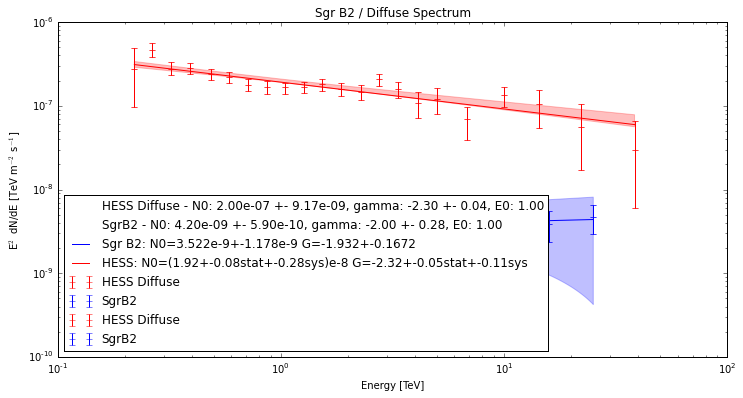

In [14]:
power = 2.
mult_factor = 10 # to put diffuse and Sgr B2 closer 

# transpose so each variable is a list
diffuse_points = np.genfromtxt(gc_dir+"/spectralPoints/HESS_diffuse_spectrum_E2flux_TeV-m2.csv")
diffuse_points *= mult_factor # to put it closer for comparison
diffuse_points[0] /= mult_factor 
# values are E^2 * flux 
SgrB2_points = np.genfromtxt(gc_dir+"/spectralPoints/SgrB2_spectral_flux_TeV-m2.txt")
#SgrB2_points *= 1e-4 # 
#SgrB2_points[:,0] *= 1e4 # don't want to adjust energy 
# values are just flux 

plt.errorbar(diffuse_points[0], diffuse_points[1]*diffuse_points[0]**(power-2.), 
             yerr=(diffuse_points[2]*diffuse_points[0]**(power-2.), 
                   diffuse_points[3]*diffuse_points[0]**(power-2.)), 
             marker='+', ls='', color='red', label='HESS Diffuse')
plt.errorbar(SgrB2_points[:,0], SgrB2_points[:,1]*SgrB2_points[:,0]**power, 
             yerr=SgrB2_points[:,2]*SgrB2_points[:,0]**power, 
             marker='_', ls='', color='blue', label='SgrB2')

plotPythonFit(diffuse_points[0], diffuse_points[1]/diffuse_points[0]**2, 
              (diffuse_points[2]/diffuse_points[0]**2,diffuse_points[3]/diffuse_points[0]**2), 
              name="HESS Diffuse", color='red', ls='')
plotPythonFit(SgrB2_points[:,0], SgrB2_points[:,1], SgrB2_points[:,2], 
              name='SgrB2', color='blue', ls='')

E_SgrB2 = np.linspace(SgrB2_points[0,0], SgrB2_points[-1,0], 100)
flux_SgrB2 = 3.522e-9 * np.power(E_SgrB2, -1.932+power)
plt.plot(E_SgrB2, flux_SgrB2, color='blue', ls='-', marker='', 
         label="Sgr B2: N0=3.522e-9+-1.178e-9 G=-1.932+-0.1672")

E_diffuse = np.linspace(diffuse_points[0,0], diffuse_points[0,-1], 100)
flux_diffuse = 1.92e-8 * np.power(E_diffuse, -2.32+power)
plt.plot(E_diffuse, flux_diffuse*mult_factor, color='red', ls='-', marker='', 
         label="HESS: N0=(1.92+-0.08stat+-0.28sys)e-8 G=-2.32+-0.05stat+-0.11sys")


plt.title("Sgr B2 / Diffuse Spectrum")
plt.loglog()
#plt.ylim(ymin=3e-14)
plt.legend(loc="best")
plt.xlabel("Energy [TeV]")
plt.ylabel(r"E$^2$ dN/dE [TeV m$^{-2}$ s$^{-1}$]")

plt.savefig(gc_dir+"/plots/spectra/SgrB2_diffuse_spectra_HESSoverlay.png")


<h2>G0.9+0.1</h2>

    col1      col2     col3     col4  
----------- -------- -------- --------
0.219663387 2.32e-07 3.17e-07  1.5e-07
0.366471541 8.03e-08 9.39e-08 6.52e-08
0.650552926 2.26e-08 2.64e-08  1.9e-08
1.164773919  6.7e-09 7.96e-09 5.63e-09
2.071088959 1.22e-09 1.64e-09 8.35e-10
3.886862492 1.52e-10 2.89e-10 4.38e-11
6.086655929 9.03e-11 1.49e-10 3.31e-11
parameters:
[-18.63480503  -2.33671409]
covariance matrix
[[ 0.01005593  0.00567634]
 [ 0.00567634  0.0169826 ]]
0.832585066037
parameters:
[-18.81197514  -2.26931485]
covariance matrix
[[ 0.13397958 -0.07840876]
 [-0.07840876  0.05178698]]
0.0517846655609
parameters:
[-18.70645201  -2.46577813]
covariance matrix
[[ 0.37985178 -0.17738659]
 [-0.17738659  0.09484911]]
0.141706966081


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


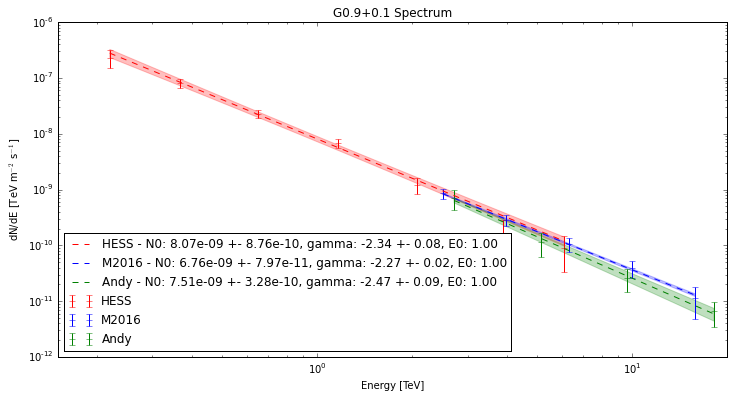

In [15]:
power = 0.
# all energies in TeV 
G09_points_M2016 = astropy.io.ascii.read(gc_dir+"/spectralPoints/G09+01_allOff_flux_TeV-m2.txt")
# need to fix HESS points, to give actual size of error bars 
G09_points_HESS = astropy.io.ascii.read(gc_dir+"/spectralPoints/G09+01_HESS_2005_flux_TeV-cm2.csv")
G09_points_Andy = astropy.io.ascii.read(gc_dir+"spectralPoints/G09+01_Andy_email_flux_m2.txt")
#G09_points_Andy = astropy.io.ascii.read(gc_dir+"spectralPoints/G09+01_Andy_spectral_points_E2-ergs.txt")


# convert cm^-2 to m^-2 
G09_points_HESS['col2'] *= 1e4
G09_points_HESS['col3'] *= 1e4
G09_points_HESS['col4'] *= 1e4
G09_points_Andy['col2'] *= 1e4
G09_points_Andy['col3'] *= 1e4

print(G09_points_HESS)

#plt.errorbar(G09_points_M2016['col1'], G09_points_M2016['col2'], G09_points_M2016['col3'], 
#            label='M2016', ls='', marker='_')
#plt.errorbar(G09_points_HESS['col1'], G09_points_HESS['col2'], 
#             (G09_points_HESS['col2']-G09_points_HESS['col4'], G09_points_HESS['col3']-G09_points_HESS['col2']),
#            label="HESS", ls='', marker='_')
#plt.errorbar()
#plt.errorbar(G09_points_Andy['col1'], G09_points_Andy['col2']/erg2TeV, G09_points_Andy['col3']/erg2TeV, label="Andy", ls='')

plotPythonFit(G09_points_HESS['col1'], G09_points_HESS['col2'], 
             (G09_points_HESS['col2']-G09_points_HESS['col4'], G09_points_HESS['col3']-G09_points_HESS['col2']), 
              color='red', name='HESS') 
plotPythonFit(G09_points_M2016['col1'], G09_points_M2016['col2'], 
              G09_points_M2016['col3'], 
              color='blue', name='M2016') 
plotPythonFit(G09_points_Andy['col1'], G09_points_Andy['col2']*1e-4/erg2TeV, G09_points_Andy['col3']*1e-4/erg2TeV, 
              name="Andy", color='green')


plt.title("G0.9+0.1 Spectrum ")
plt.loglog(nonposy="clip")
plt.legend(loc="best")
#plt.xlabel("Energy [TeV]")
plt.xlim(xmin=0.15, xmax=20)
# think this is just dN/dE
plt.ylabel(r"dN/dE [TeV m$^{-2}$ s$^{-1}$]")

plt.savefig(gc_dir+"/plots/spectra/G09_spectra_HESSoverlay_wAndy.png")



parameters:
[-18.81197514  -2.26931485]
covariance matrix
[[ 0.13397958 -0.07840876]
 [-0.07840876  0.05178698]]
0.0517846655609


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


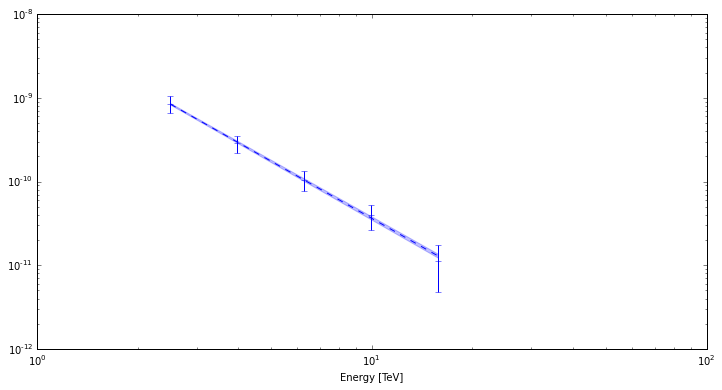

In [16]:
plotPythonFit(G09_points_M2016['col1'], G09_points_M2016['col2'], G09_points_M2016['col3'], 
                'blue', name='M2016')


<h2> Disp 5t / LZA / Crab Validation

[3.27727e-07, -2.43964, 5.72805e-09, 0.0156776]
parameters:
[-14.96121544  -2.42111303]
covariance matrix
[[ 0.00214977  0.00150296]
 [ 0.00150296  0.00223811]]
0.85069884389
parameters:
[-14.95164587  -2.51725689]
covariance matrix
[[ 0.00267048 -0.00152916]
 [-0.00152916  0.00267438]]
1.20368285128


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


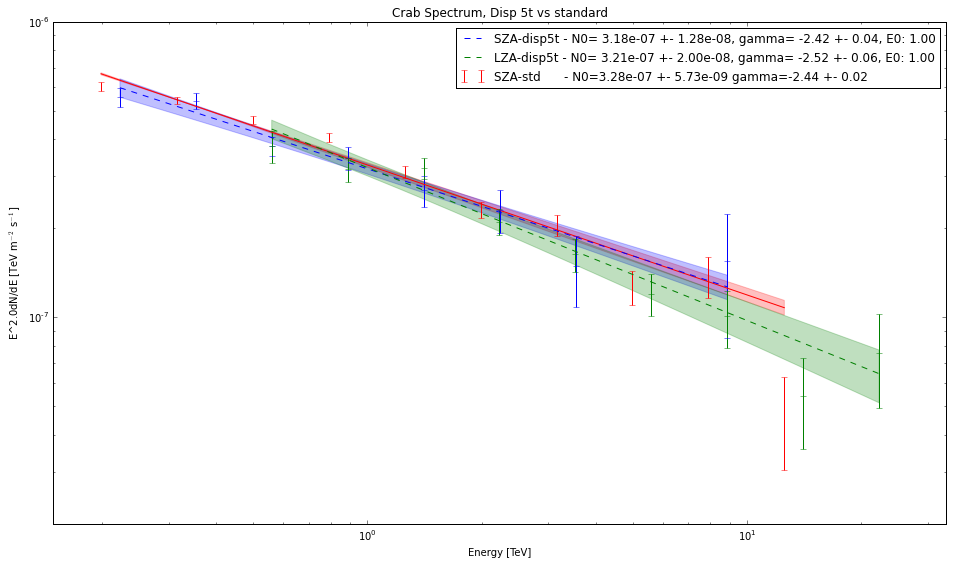

In [98]:
#def 

power = 2.
plt.rcParams["figure.figsize"] = (16, 9)
plt.ylabel(r"E^2 dN/dE [TeV m$^{-2}$ s$^{-1}$]")

crab_dir = home + "/Dropbox/VEGAS/Crab"
logfile = home + "/Dropbox/VEGAS/NERSC/validation/stage6/Crab_validation_V5_medium_rc6_stage6.txt"

# disp 5t 
sza_points = np.genfromtxt(crab_dir+"/spectralPoints/spectral_points_Crab_SZA.txt")
lza_points = np.genfromtxt(crab_dir+"/spectralPoints/spectral_points_Crab_LZA.txt")
# fit parameters from VEGAS output 
sza_params = [3.133e-7, -2.427, 1.470e-8, 0.04705] # norm, index, norm_err, index_err 
lza_params = [3.157e-7, -2.525, 1.584e-8, 0.04649]
flux_sza = sza_params[0] * np.power(E_sza, sza_params[1]+power)
flux_lza = lza_params[0] * np.power(E_lza, lza_params[1]+power)

# standard analysis
standard_points, params_std = extract_spectral_points_from_log(logfile)
E_std = standard_points[:,1]
Epow = np.power(E_std, power) # e.g. E^2 dN/dE 
y_std = standard_points[:,3] * Epow
yerr_std = standard_points[:,4] * Epow
std_label = ("SZA-std      - N0={0:.2e} +- {1:.2e} gamma={2:.2f} +- {3:.2f}")
std_label = std_label.format(params_std[0], params_std[2], params_std[1], params_std[3])

plt.errorbar(E_std, y_std, yerr_std, ls='', color='red', label=std_label)
E     = np.linspace(E_std[0], E_std[-1], num=100)
plt.plot(E, params_std[0]*np.power(E, params_std[1]+power), color='red', ls='-')
flux_upper = (params_std[0]+params_std[2])*np.power(E, params_std[1]+params_std[3]+power)
flux_lower = (params_std[0]-params_std[2])*np.power(E, params_std[1]-params_std[3]+power)
plt.fill_between(E, flux_upper, flux_lower, color='red', alpha='0.25')

plt.title("Crab Spectrum, Disp 5t vs standard")
plt.xlabel("Energy [TeV]")
plt.xlim(sza_points[0,0]/1.5, lza_points[-1,0]*1.5)
plt.ylim(2e-8, 1e-6)
plt.ylabel(r"E^"+str(power)+"dN/dE [TeV m$^{-2}$ s$^{-1}$]")
plt.loglog()

E_sza = np.linspace(sza_points[0,0], sza_points[-1,0], 100)
E_lza = np.linspace(lza_points[0,0], lza_points[-1,0], 100)

plotPythonFit(sza_points[:,0], sza_points[:,1], sza_points[:,2], name='SZA-disp5t', color='blue')
plotPythonFit(lza_points[:,0], lza_points[:,1], lza_points[:,2], name='LZA-disp5t', color='green')


#plotPythonFit(standard_points[:,1], standard_points[:,3], standard_points[:,4], name='standard', color='red')
#plt.plot(E_sza, flux_sza, color='blue', ls='-', marker='', label="SZA: N0=3.133e-7+-1.47e-8 G=-2.427+-0.04705")
#plt.plot(E_lza, flux_lza, color='green', ls='-', marker='', label="LZA: N0=3.157e-7+-1.584e-8 G=-2.525+-0.04649")
#plt.fill_between(E, (E)**power*(sza_params[+Ferr), (E)**power*(F-Ferr), color=color, alpha='0.25')



plt.legend(loc="best")
plt.savefig(home+"/Dropbox/VEGAS/Crab/plots/Crab_disp5t_SZAvLZA_spectrum_E"+str(power)+"dNdE.png")

# add upper limit 

# :,0 gives energy - then flux, error 
#plt.errorbar(sza_points[:,0], 
#             sza_points[:,1]*sza_points[:,0]**power, 
#             sza_points[:,2]*sza_points[:,0]**power, 
#             label='SZA', ls='', color='blue', marker='_')
#plt.errorbar(lza_points[:,0], 
#                 lza_points[:,1]*lza_points[:,0]**power, 
#                 lza_points[:,2]*lza_points[:,0]**power, 
#                 label='LZA', ls='', color='green', marker='_')


<h2> Plot multiple spectra from log file </h2>


In [38]:
from matplotlib import pyplot as plt  
%matplotlib inline 

def plot_all_epochs(cuts):
    """"""
    epochs = ('V4', 'V5', 'V6')
    logdir = home + "/Dropbox/VEGAS/NERSC/validation/stage6"
    plotdir = home + "/Dropbox/VEGAS/NERSC/validation/plots"

    plt.clf()
    plt.loglog()
    plt.title("Crab spectrum: " + cuts + " cuts")
    plt.xlabel("Energy (TeV)")
    plt.ylabel("Flux [g's/m^2/TeV/s]")
    
    for epoch in epochs:
        base = "Crab_validation_" + epoch + '_' + cuts + "_rc6"
        fn = logdir + "/" + base + "_stage6.txt" 
        print(fn)
        flux_points, fitparams = extract_spectral_points_from_log(fn)

        label = "Norm: " + str(fitparams[0]) + "  Index: " + str(fitparams[1])
        
        bins = flux_points[:,0].astype(np.int)
        energy = flux_points[:,1]
        #energyerr = flux_points[:,2]
        flux = flux_points[:, 3]
        fluxerr = flux_points[:, 4]
        
        plot = plt.errorbar(energy, flux, fluxerr, ls='', label=label)
    # loop over epochs 
    plt.legend(loc='best', ncol=1)

    plotname = plotdir + "/Crab_validation_rc6_" + cuts + ".png" 
    plt.savefig(plotname)
    
        
# plot_all_epochs 
    

/Users/mbuchove/Dropbox/VEGAS/NERSC/validation/stage6/Crab_validation_V4_medium_rc6_stage6.txt
[3.62737e-07, -2.45387]
/Users/mbuchove/Dropbox/VEGAS/NERSC/validation/stage6/Crab_validation_V5_medium_rc6_stage6.txt
[3.27727e-07, -2.43964]
/Users/mbuchove/Dropbox/VEGAS/NERSC/validation/stage6/Crab_validation_V6_medium_rc6_stage6.txt
[2.75126e-07, -2.45201]
/Users/mbuchove/Dropbox/VEGAS/NERSC/validation/stage6/Crab_validation_V4_hard_rc6_stage6.txt
[3.84539e-07, -2.58036]
/Users/mbuchove/Dropbox/VEGAS/NERSC/validation/stage6/Crab_validation_V5_hard_rc6_stage6.txt
[3.39754e-07, -2.52583]
/Users/mbuchove/Dropbox/VEGAS/NERSC/validation/stage6/Crab_validation_V6_hard_rc6_stage6.txt
[2.88073e-07, -2.53475]
/Users/mbuchove/Dropbox/VEGAS/NERSC/validation/stage6/Crab_validation_V4_soft_rc6_stage6.txt
[3.69072e-07, -2.41091]
/Users/mbuchove/Dropbox/VEGAS/NERSC/validation/stage6/Crab_validation_V5_soft_rc6_stage6.txt
[3.22607e-07, -2.41308]
/Users/mbuchove/Dropbox/VEGAS/NERSC/validation/stage6/Crab

/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


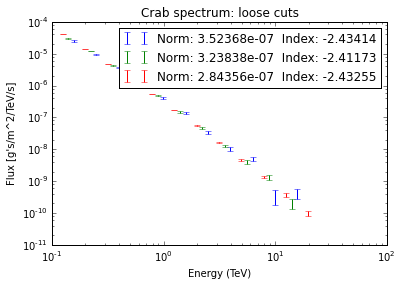

In [39]:
all_cuts = ('medium', 'hard', 'soft', 'loose')

for cut in all_cuts:
    plot_all_epochs(cut)


<h1> TESTING </h1>

In [ ]:
import collections 
from collections import namedtuple
from tempfile import mkstemp
import os 


flux_point = collections.namedtuple('flux_point', " bin energy energyerr flux fluxerr Non Noff Nexcess RawOff alpha sig eLow eHigh")


#file = open()

    #points_file = os.open(pfilename)
    #handle, pfilename = mkstemp()
    #points_file = os.fdopen(handle, 'w')

    #points_file.seek(0)
    #points_file.read()
 

    #flux_points = np.genfromtxt(open(points_file))
    #flux_points = np.genfromtxt(pfilename)

    #points_file.delete()
        #

        
                        #print(flux_points)
        #print(UL_points)


In [43]:
# define our (line) fitting function
fitfunc = lambda p, x: p[0] + p[1] * (x)
errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

# define our (line) fitting function
fitfuncECPL = lambda p, x: p[0] + p[1] * np.log(x) - (x) / p[2]
errfuncECPL = lambda p, x, y, err: (np.log(y) - fitfuncECPL(p, x)) / (err)

fitfuncECPL_CF = lambda N0, gamma, beta, E: N0 + gamma * E -1.*np.exp(E) / beta 


#these are just copied from http://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/python_tutorial.html
f = lambda E,N0,E0,gamma: N0*(E/E0)**(-1.*gamma)
ferr = lambda E,F,N0,N0err,E0,cov_gg: F*np.sqrt(N0err**2/N0**2 + ((np.log(E/E0))**2)*cov_gg)

f_ecpl = lambda E,N0,E0,gamma,beta: N0*(E/E0)**(-1.*gamma)*np.exp(-1.*E/beta)
ferr_ecpl = lambda E,F,N0,N0err,E0,cov_gg,b,cov_bb: F*np.sqrt(N0err**2/N0**2 \
                                                              + ((np.log(E/E0))**2) * cov_gg \
                                                              + (E/E0)**2 / b**4 * cov_bb)

def plotPythonFit_ralph(energy, flux, fluxEr, color, cuts='nocuts', ECPL = False, E0 = 1):
    logx = np.log(energy/E0)
    logy = np.log(flux)
    logyerr = fluxEr / flux

    if ECPL:
        pinit = [-26, -2.25, 10]
        out = optimize.leastsq(errfuncECPL, pinit,
                               args=(energy/E0, flux, fluxEr / flux), 
                               full_output=1)
# #         print out
# #         pinit = [out[0][0], -1.*out[0][1], out[0][2]]
# #         print pinit
#         out = optimize.curve_fit(fitfuncECPL_CF, logx, logy, 
#                                  p0=pinit,
#                                  sigma=fluxEr, 
#                                 bounds = ([-30.,-3.,1.],[-25.,-2.,1e2]))
#    absolute_sigma = True, 
#         print out
#         out = optimize.leastsq(errfuncECPL, pinit,
#                                args=(energy, flux, fluxEr / flux), 
#                                full_output=1)
    else:
        pinit = [-26, -2.25] # nb ln
    
        out = optimize.leastsq(errfunc, pinit,
                               args=(logx, logy, logyerr), 
                               full_output=1)

    pfinal = out[0]
    covar  = out[1]
    print (pfinal)
    print (np.diag(covar))
    
    N0    = np.exp(pfinal[0])
    gamma = pfinal[1]
    
    E    = np.linspace(energy[0],energy[-1],num=100)
    if ECPL:
        beta = pfinal[2]
        
        F    = f_ecpl(E,N0,E0, -1. * gamma, beta)
        chi2  = np.sum((flux - f_ecpl(energy,N0,E0, -1. * gamma, beta))**2/fluxEr**2) / (len(energy) - 3)
        print(chi2)

        beta_err  = np.sqrt( covar[2][2] ) * chi2 #* N0  
        gamma_err = np.sqrt( covar[0][0] ) * chi2
        N0_err    = np.sqrt( covar[1][1] ) * N0 * chi2
        cov_gg = gamma_err**2
        cov_bb = beta_err**2
        Ferr = ferr_ecpl(E,F,N0,N0_err,E0,cov_gg,beta,cov_bb)

        fitTitle = (cuts + ' - N0: {0:.2e} +- {2:.2e}, '\
                    'G: {1:.2f} +- {3:.2f}, '\
                    'Ec: {4:.2f} +- {5:.2f}, '
                    'E0: {6:.0f}').format(float(N0), float(gamma),
                                          float(N0_err), float(gamma_err),
                                          float(beta), float(beta_err), float(E0))

    else:
        F    = f(E,N0,E0, -1. * gamma)
        chi2  = np.sum((flux - f(energy, N0, E0, -1. * gamma))**2/fluxEr**2) / (len(energy) - 2)
        print (chi2)
        gamma_err = np.sqrt( covar[0][0] ) * chi2
        N0_err    = np.sqrt( covar[1][1] ) * N0 * chi2
        cov_gg = gamma_err**2
        Ferr = ferr(E,F,N0,N0_err,E0,cov_gg)
        
        fitTitle = (cuts + ' - N0: {0:.2e} +- {2:.2e}, '\
                    'gamma: {1:.2f} +- {3:.2f}, '\
                    'E0: {4:.2f}').format(float(N0), float(gamma),
                                          float(N0_err), float(gamma_err), float(E0))


    plt.plot(E, F * (E)**power, color=color, ls="--", marker="", label = fitTitle)
    plt.fill_between(E, (E)**power*(F+Ferr), (E)**power*(F-Ferr), color=color, alpha='0.25')
    

[ 0.44764398  0.54712042  0.64921466  0.7460733   0.84554974  0.94502618
  1.09424084  1.29319372  1.4921466 ]


/Users/mbuchove/Programs/Anaconda3/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


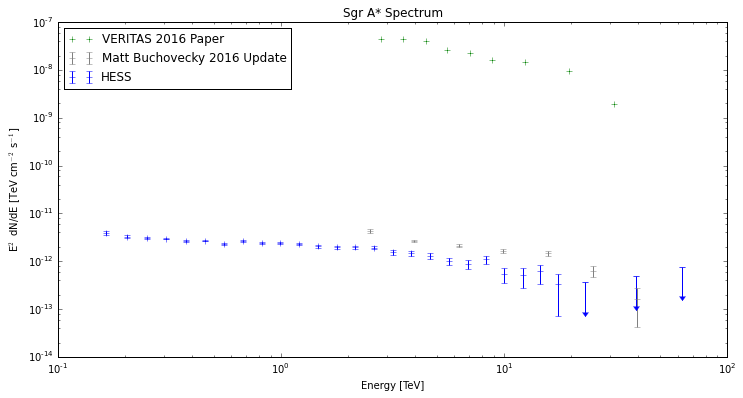

In [22]:
power = 2.
err_bar_red = sqrt(2) # projection for doubled dataset 

# my VEGAS points
#plotPythonFit(V_Points['col1'], V_Points['col2'], V_Points['col3'], name="M2016", color="gray", ECPL=True, E0=1.0)
plt.errorbar(V_Points['col1'], V_Points['col2'] * V_Points['col1']**power, 
             yerr = V_Points['col3'] * V_Points['col1']**power,
             label = "Matt Buchovecky 2016 Update", ls="", marker="_", color="gray")

# HESS points
plt.errorbar(H_energy[:-3], H_energy[:-3]**2*H_flux[:-3], 
             yerr=H_energy[:-3]**2*(H_err_dwn[:-3], H_err_up[:-3]), 
             marker="+", ls="", color="blue", label="HESS")
plt.errorbar(H_energy[-3:], H_energy[-3:]**2*H_flux[-3:], 
             yerr=(H_energy[-3:]**2*H_err_up[-3:], H_energy[-3:]**2*H_err_dwn[-3:]), 
             marker="_", ls="", uplims=True, color="blue")

# Andy's points 
And_p = np.genfromtxt(gc_dir+"/spectralPoints/SgrA_Andy2016_E2flux_erg-m2.csv")

plt.plot(And_p[:,0], And_p[:,1] * And_p[:,0]**(power-2.), 
#             yerr = And_p[:,] * And_p[:,0]**(power-2.),
            label = "VERITAS 2016 Paper", ls="", marker="+", color="green")


# plot format and save 
plt.title("Sgr A* Spectrum ")
plt.loglog(nonposy="clip")
#plt.ylim(ymin=1e-15)
plt.legend(loc="best")
plt.xlabel("Energy [TeV]")
plt.ylabel(r"E$^2$ dN/dE [TeV cm$^{-2}$ s$^{-1}$]")

print(log10(And_p[:,0]))

plt.savefig(gc_dir+"/plots/spectra/SgrA_spectra_HESSoverlay_wAndy_ECPL_projected.png")


In [55]:
def extract_spectral_points(logfile, power=2.):
    """supply a stage 6 log file and get the spectral points from it"""
    points = [[], [], []]
    bin = 0
    begin = False
    with open(logfile) as file:
        for line in file:
            split = line.split()
            if len(split) > 1 and split[0] == "Bin" and split[1] == "Energy":
                begin = True
            elif "FCN=" in line:
                begin = False
            elif begin and split[0] == '+':
                points[0].append(float(split[2]))
                points[1].append(float(split[4])*float(split[2])**power)
                points[2].append(float(split[5])*float(split[2])**power)
                bin += 1
                
    return points
    
V5 = extract_spectral_points(gc_dir+"/log/stage6/SgrA_V5_disp5t_4tel_stage6.txt")    
V6 = extract_spectral_points(gc_dir+"/log/stage6/SgrA_V6_disp5t_4tel_stage6.txt")
allOff = extract_spectral_points(gc_dir+"/log/stage6/SgrA_test_allOff_stage6.txt")
mine_rl = extract_spectral_points(gc_dir+"/log/stage6/stage6_Andy_SgrA_spectrum.txt") # me running Andy's runlist
msb = extract_spectral_points(gc_dir+"/log/stage6/SgrA_bin_Andy_no69365_stage6.txt")

# comparison with Andy
A_c_a = np.genfromtxt(gc_dir+"spectralPoints/SgrA_spectrum_Andy_runlist_comparison_E2flux_ergs-cm2.csv")
A_c_m = np.genfromtxt(gc_dir+"spectralPoints/SgrA_spectrum_Matt_runlist_comparison_E2flux_ergs-cm2.csv")

print(A_c_a[1]*1e4*erg2TeV)

        #"  Bin    Energy    error     Flux    error  Non    Noff Nexcess  RawOff Alpha    Sig  Low Edge High Edge":


[  2.47395303e+04   2.66296400e-08]
